#### New to Plotly?
Plotly's Python library is free and open source! [Get started](https://plot.ly/python/getting-started/) by downloading the client and [reading the primer](https://plot.ly/python/getting-started/).
<br>You can set up Plotly to work in [online](https://plot.ly/python/getting-started/#initialization-for-online-plotting) or [offline](https://plot.ly/python/getting-started/#initialization-for-offline-plotting) mode, or in [jupyter notebooks](https://plot.ly/python/getting-started/#start-plotting-online).
<br>We also have a quick-reference [cheatsheet](https://images.plot.ly/plotly-documentation/images/python_cheat_sheet.pdf) (new!) to help you get started!

### Version Check
Note: The static image export API is available in version <b>3.2.0.+</b><br>

In [1]:
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

plotly.__version__

'3.2.0a2'

### Overview
This section covers the lower-level details of how plotly.py uses orca to perform static image generation. Please refer to the [Static Image Export](../static-image-export/) section for general information on creating static images from plotly.py figures.

### What is Orca?
Orca is an [Electron](https://electronjs.org/) application that inputs plotly figure specifications and converts them into static images.  Orca can run as a command-line utility or as a long-running server process. In order to provide the fastest possible image export experience, plotly.py launches orca in server mode, and communicates with it over a local port. See https://github.com/plotly/orca for more information.

By default, plotly.py launches the orca server process the first time an image export operation is performed, and then leaves it running until the main Python process exits. Because of this, the first image export operation in an interactive session will typically take a couple of seconds, but then all subsequent export operations will be significantly faster, since the server is already running.

### Create a Figure
Now let's create a simple scatter plot with 100 random points of variying color and size.

In [2]:
import plotly.graph_objs as go
import plotly.io as pio

import os
import numpy as np

We'll configure the notebook for use in [offline](https://plot.ly/python/getting-started/#initialization-for-offline-plotting) mode

In [3]:
init_notebook_mode(connected=True)

In [4]:
N = 100
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
sz = np.random.rand(N)*30

fig = go.Figure()
fig.add_scatter(x=x,
                y=y,
                mode='markers',
                marker={'size': sz,
                        'color': colors,
                        'opacity': 0.6,
                        'colorscale': 'Viridis'
                       });
iplot(fig)

### config
We can use the `plotly.io.orca.config` object to view the current orca configuration settings.

In [5]:
pio.orca.config

orca configuration
------------------
    executable: orca
    port: None
    timeout: None
    default_width: None
    default_height: None
    default_scale: 1
    default_format: png
    mathjax: https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js
    topojson: None
    mapbox_access_token: None

constants
---------
    plotlyjs: /Users/jmmease/Plotly/repos/plotly.py/plotly/package_data/plotly.min.js 
    config_file: /Users/jmmease/.plotly/.orca


### status
We can use the `plotly.io.orca.status` object to see the current status of the orca server

In [6]:
pio.orca.status

orca status
-----------
    state: unvalidated
    executable: None
    version: None
    port: None
    pid: None
    command: None
    

Since no image export operations have been performed yet, the orca server is not yet running.

Let's export this figure as an SVG image, and record the runtime.

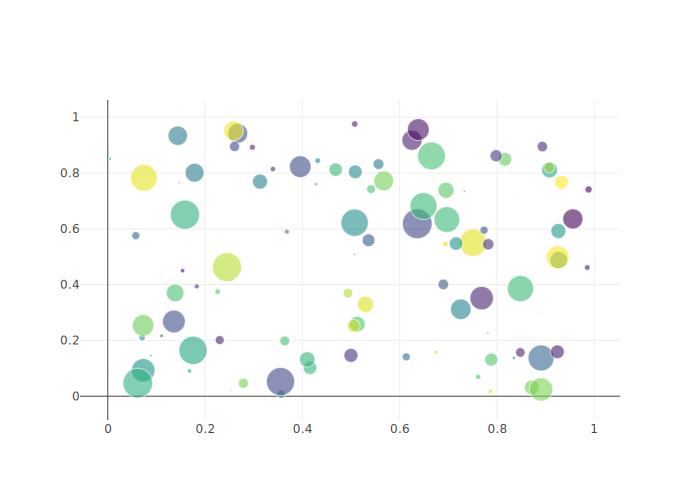

CPU times: user 416 ms, sys: 67.1 ms, total: 483 ms
Wall time: 2.07 s


In [7]:
%%time
img_bytes = pio.to_image(fig, format='svg')
from IPython.display import SVG, display
display(SVG(img_bytes))

By checking the `status` object again, we see that the orca server is now running

In [8]:
pio.orca.status

orca status
-----------
    state: running
    executable: /usr/local/bin/orca
    version: 1.1.0
    port: 54948
    pid: 51423
    command: ['/usr/local/bin/orca', 'serve', '-p', '54948', '--plotly', '/Users/jmmease/Plotly/repos/plotly.py/plotly/package_data/plotly.min.js', '--graph-only', '--mathjax', 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js']
    

Let's perform this same export operation again, now that the server is already running.

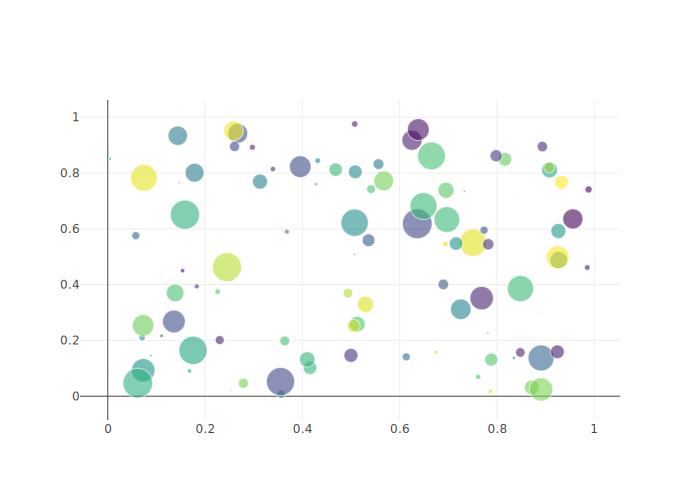

CPU times: user 22.2 ms, sys: 3.02 ms, total: 25.2 ms
Wall time: 86.9 ms


In [9]:
%%time
img_bytes = pio.to_image(fig, format='svg')
display(SVG(img_bytes))

The difference in runtime is dramatic. Starting the server and exporting the first image takes a couple seconds, while exporting an image with a running server is much faster.

### Shutdown the Server
By default, the orca server will continue to run until the main Python process exits.  It can also be manually shut down by calling the `plotly.io.orca.shutdown_server()` function.  Additionally, it is possible to configure the server to shut down automatically after a certain period of inactivity. See the `timeout` configuration parameter below for more information.

Regardless of how the server is shut down, it will start back up automatically the next time an image export operation is performed.

In [10]:
pio.orca.shutdown_server()
pio.orca.status

orca status
-----------
    state: validated
    executable: /usr/local/bin/orca
    version: 1.1.0
    port: None
    pid: None
    command: None
    

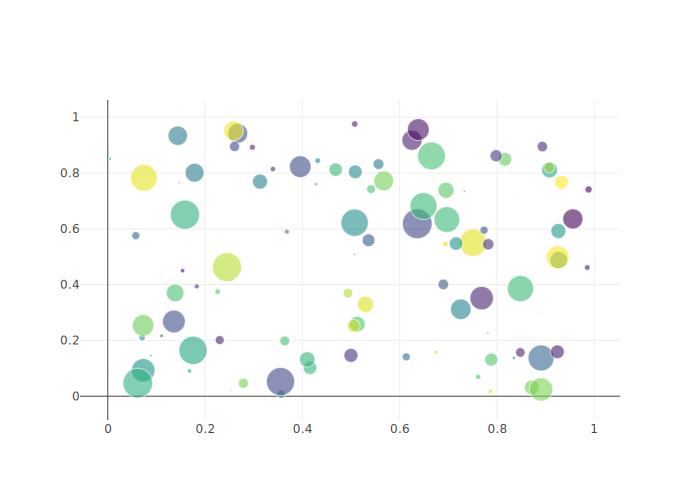

In [11]:
img_bytes = pio.to_image(fig, format='svg')
display(SVG(img_bytes))

In [12]:
pio.orca.status

orca status
-----------
    state: running
    executable: /usr/local/bin/orca
    version: 1.1.0
    port: 55179
    pid: 51426
    command: ['/usr/local/bin/orca', 'serve', '-p', '55179', '--plotly', '/Users/jmmease/Plotly/repos/plotly.py/plotly/package_data/plotly.min.js', '--graph-only', '--mathjax', 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js']
    

### Configuring the Executable
By default, plotly.py searches the `PATH` for an executable named `orca` and checks that it is a valid plotly orca executable. If plotly.py is unable to find the executable, you'll get an error message that looks something like this:

```
----------------------------------------------------------------------------
ValueError: 
The orca executable is required in order to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /anaconda3/envs/plotly_env/bin
    /usr/local/bin
    /usr/bin
    /bin
    /usr/sbin
    /sbin

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca.

After installation is complete, no further configuration should be needed. 

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path to your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save() 

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python
----------------------------------------------------------------------------
```
If this happens, follow the instructions in the error message and specify the full path to you orca executable using the `plotly.io.orca.config.executable` configuration property.

### Other Configuration Settings
In addition to the `executable` property, the `plotly.io.orca.config` object can also be used to configure the following options:

 - **`port`**: The specific port to use to communicate with the orca server, or `None` if the port will be chosen automatically.
 - **`timeout`**: The number of seconds of inactivity required before the orca server is shut down. For example, if timeout is set to 20, then the orca server will shutdown once is has not been used for at least 20 seconds. If timeout is set to `None` (the defualt), then the server will not be automatically shut down due to inactivity.
 - **`default_width`**: The default pixel width to use on image export.
 - **`default_height`**: The default pixel height to use on image export.
 - **`default_scale`**: The default image scale facor applied on image export.
 - **`default_format`**: The default image format used on export. One of `'png'`, `'jpeg'`, `'webp'`, `'svg'`, `'pdf'`, or `'eps'`.
 - **`mathjax`**: Location of the MathJax bundle needed to render LaTeX characters. Defaults to a CDN location. If fully offline export is required, set this to a local MathJax bundle.
 - **`topojson`**: Location of the topojson files needed to render choropleth traces. Defaults to a CDN location. If fully offline export is required, set this to a local directory containing the [Plotly.js topojson files](https://github.com/plotly/plotly.js/tree/master/dist/topojson).
 - **`mapbox_access_token`**: Mapbox access token required to render `scattermapbox` traces.

### Saving Configuration Settings
Configuration options can optionally be saved to the `~/.plotly/` directory by calling the `plotly.io.config.save()` method.  Saved setting will be automatically loaded at the start of future sessions.

In [2]:
from IPython.display import display, HTML

display(HTML('<link href="//fonts.googleapis.com/css?family=Open+Sans:600,400,300,200|Inconsolata|Ubuntu+Mono:400,700" rel="stylesheet" type="text/css" />'))
display(HTML('<link rel="stylesheet" type="text/css" href="http://help.plot.ly/documentation/all_static/css/ipython-notebook-custom.css">'))

! pip install git+https://github.com/plotly/publisher.git --upgrade
import publisher
publisher.publish(
    'orca-management.ipynb', 'python/orca-management/', 'Orca Management | plotly',
    'This section covers the low-level details of how plotly.py uses orca to perform static image generation.',
    title = 'Orca Management | Plotly',
    name = 'Orca Management',
    thumbnail='thumbnail/orca-management.png',
    language='python',
    uses_plotly_offline=True,
    page_type='example_index', has_thumbnail='true', display_as='file_settings', order=1.5,
    ipynb='~notebook_demo/253')

  Cloning https://github.com/plotly/publisher.git to /private/var/folders/x2/smn4tpcs0s1ft0gg294_fq7h0000gn/T/pip-req-build-M3olVO
  Running setup.py bdist_wheel for publisher ... done
  Stored in directory: /private/var/folders/x2/smn4tpcs0s1ft0gg294_fq7h0000gn/T/pip-ephem-wheel-cache-0G_UOq/wheels/99/3e/a0/fbd22ba24cca72bdbaba53dbc23c1768755fb17b3af0f33966
Successfully built publisher
  Found existing installation: publisher 0.11
    Uninstalling publisher-0.11:
      Successfully uninstalled publisher-0.11
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
